# Statistical Inference on Quantitative Characteristics of Cammeo & Osmancik Rice
**Authors:** Nour Abdelfattah, Muhammad Shahbaz Murtaza, Sky Yun and Emiliano Hernández Castillo

**Group:** 47

## 1. Introduction
The genetic varieties of rice are usually separated by specific features such as texture, shape and color. These sets of characteristics have been widely researched to be able to differentiate rice species from one another (Koklu, 2021). Most research attempts to classify different species of rice by taking a sample of rice grains and generating grain images, using a set of features and performing classification processes to predict rice species. This concept is necessary for agricultural practices and due to an increase in the world’s population and harmful environmental phenomenons such as global warming, it is important to be able to identify and use healthy, high quality seeds (Tugrul, 2022).



To analyze the features of rice species, our primary inferential question is: **Do the major axis length and perimeter in Cammeo rice differ from the major axis length and perimeter of Osmanick rice?**

This data set, `Rice_Cammeo_Osmancik`,  was originally taken from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik). The dataset contains a total of 3810 observations of two species of rice, Cammeo and Osmancik, and their corresponding morphological characteristics. The variables of interest are described below:

- `major_axis_length`: Describes the longest line that can be drawn on the grain of rice.
- `perimeter`: Calculates the circumference on the grain of rice.

## 2. Preliminary Analysis

### 2.1 Loading Library Dependencies

In [2]:
# Run this before continuing
install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# run this before continuing
library(tidyverse)   #Allows to transform and present data
library(ggplot2)     #Allows to present data vectors accordingly
library(gridExtra)   #Allows to organize presented data graphs
library(grid)        #Allows to organize presented data graphs
library(ggcorrplot)  #Allows to render correlation plot w/ according vectors
library(infer)       #Allows performance of statistical inference
library(broom)       #Allows to create tidy data and dataframes from various outputs

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2.2 Reading and Wrangling Rice Data Set into R

In [4]:
#Reading original Rice data set from Github repository to R
url<- "https://raw.githubusercontent.com/yun-sky/stat-201-project/main/Rice_Cammeo_Osmancik.arff"
rice_data <- read.csv(url, header=FALSE, comment.char = "@", skip = 4) |>
                      type.convert(as.is= TRUE) #Converting character data type into double data type                  

#Assigning correct column names
colnames(rice_data) <- c("area", "perimeter", "major_axis_length", "minor_axis_length", "eccentricity", 
                            "convex_area", "extent", "class")


### 2.3 Exploratory Data Analysis

We want to observe the correlation of class between variables. We will choose our variables accordingly by calculating the **point-biserial correlation** between the class of rice and all the continuous variables.

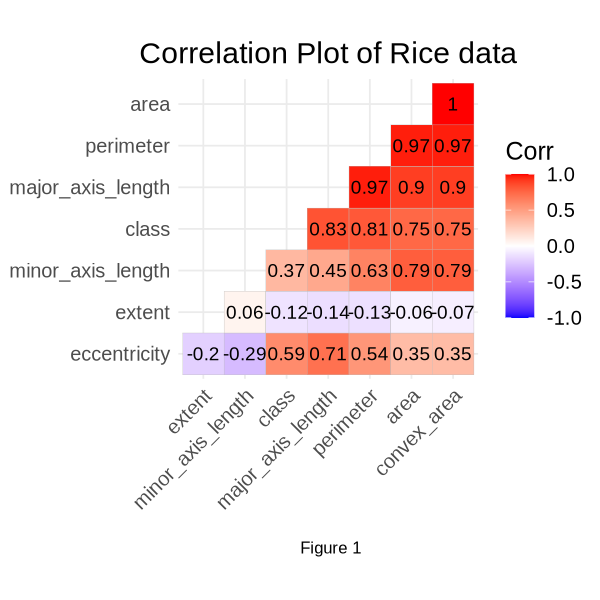

In [5]:
options(repr.plot.width = 5, repr.plot.height = 5)

#Converting Data set into binary class variable and correct vectors for Corr plot
binary_data <- rice_data |>
     mutate(class = ifelse(class == "Cammeo",1,0)) |>
     cor(use="complete.obs") 

#Plotting Corr plot
ggcorrplot(binary_data, 
           hc.order = TRUE, 
           type = "lower",
           lab = TRUE) +

labs(title = "Correlation Plot of Rice data",
     caption = "\n Figure 1") +

theme(text = element_text(size = 15),
      plot.title = element_text(hjust = 0.5),
      plot.caption = element_text(size = 10, hjust = 0.5))

*Figure 1.0* indicates that the `major_axis_length` and the `perimeter` have the highest correlation with `class`. Thus we will analyze these variables to determine if  there are differences between properties of Cammeo and Osmancik Rice.

In [6]:
#Given Correlation plot we can select our variables from the data set
cleaned_rice_data <- rice_data|>
                     select(perimeter, major_axis_length, class) 

head(cleaned_rice_data) 

perimeter major_axis_length class 
1 525.579   229.7499          Cammeo
2 494.311   206.0201          Cammeo
3 501.122   214.1068          Cammeo
4 458.343   193.3374          Cammeo
5 507.167   211.7434          Cammeo
6 477.016   200.0531          Cammeo

 To further analyze this correlation, we will plot the side-by-side boxplots for each of our variables of interest. 

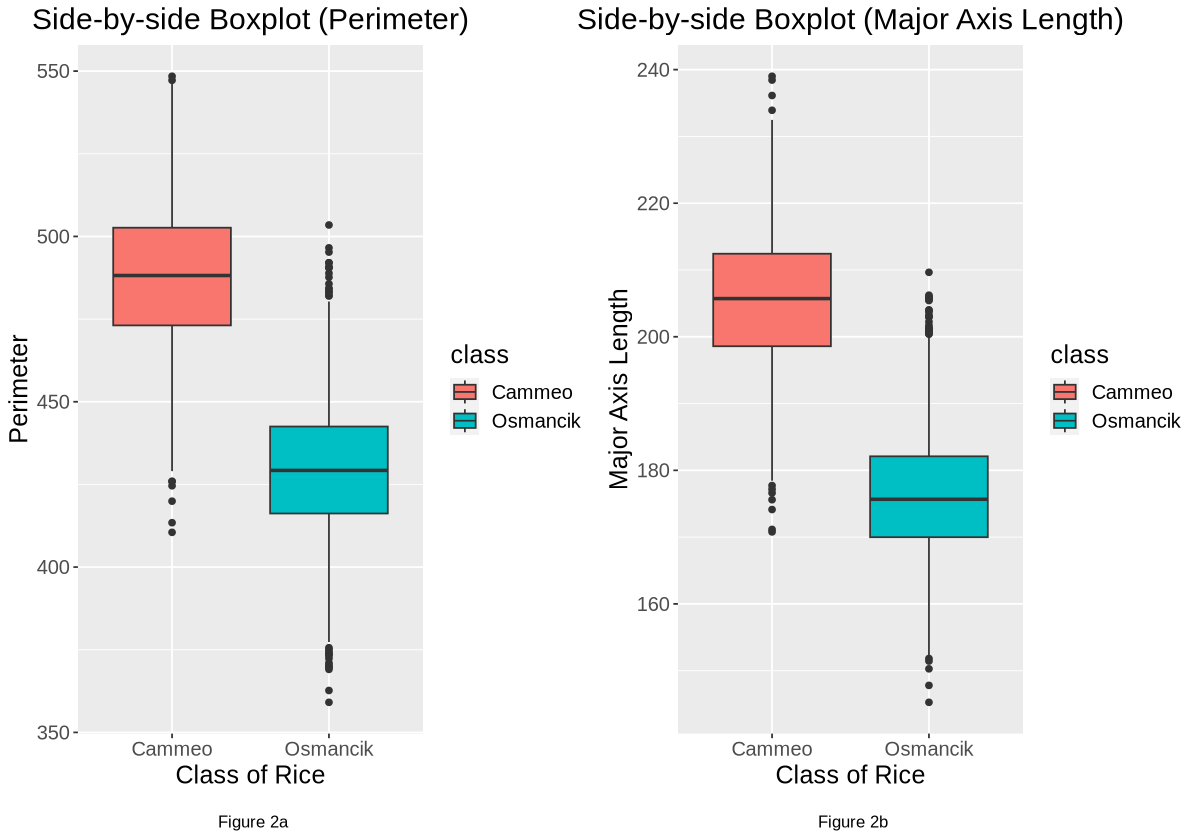

In [7]:
options(repr.plot.width = 10, repr.plot.height = 7)

#Plotting major_axis_length vs class box plot
mal_plot <- ggplot(cleaned_rice_data, aes(x = class, y = major_axis_length)) +  
    geom_boxplot(aes(fill = class)) +
    xlab("Class of Rice") +
    ylab("Major Axis Length") +
    labs(title = "Side-by-side Boxplot (Major Axis Length)",
         caption = "\n Figure 2b") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))



#Plotting perimeter vs class boxplot
peri_plot <- ggplot(cleaned_rice_data, aes(x = class, y = perimeter)) +
    geom_boxplot(aes(fill = class)) +
    xlab("Class of Rice") +
    ylab("Perimeter") +
    labs(title = "Side-by-side Boxplot (Perimeter)",
         caption = "\n Figure 2a") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))



#Arranges the plots in a neater format
grid.arrange(peri_plot, mal_plot, ncol = 2)

From our boxplots in *Figure 2a & 2b*, it can be inferred that the mean Cammeo rice has a larger perimeter and major axis length than Osmancik. However, to explore this quantitatively, we will do hypothesis testing. But first, we will calculate the data parameter estimates from our sample.

### 2.4 Data Parameter Estimates

In [10]:
# Calculating the mean and standard deviation for each selected class
summary_rice <- cleaned_rice_data |>
    group_by(class) |>
    summarize(mean_perimeter = mean(perimeter), mean_mal = mean(major_axis_length), 
              sd_perimeter = sd(perimeter), sd_mal = sd(major_axis_length))

summary_rice

class    mean_perimeter mean_mal sd_perimeter sd_mal   
1 Cammeo   487.4389       205.4786 22.18152     10.333854
2 Osmancik 429.4155       176.2878 20.15439      9.362405

In [11]:
# Calculating the parameters of interest: difference in means for the perimeter and major axis length
rice_estimates <- summary_rice %>%
    pivot_wider(names_from = class, values_from = c(mean_perimeter, mean_mal, sd_perimeter, sd_mal)) |>
    mutate(mean_diff_perimeter = mean_perimeter_Cammeo - mean_perimeter_Osmancik,
           mean_diff_mal       = mean_mal_Cammeo - mean_mal_Osmancik) |>
    select(mean_diff_perimeter, mean_diff_mal)

rice_estimates

mean_diff_perimeter mean_diff_mal
1 58.02344            29.19083

## 3. Methods: Plan


As our dataset was collected from a reputable source and the analysis done was peer-reviewed, we feel confident in our initial findings. Although our visualizations allow us to draw inferences about the relationships between our predictors and response, they do not prove anything. To do so, we hypothesize below and later test those claims:

**Difference in means**
- $H_0: \mu_1 - \mu_2 = 0$
- $H_A: \mu_1 - \mu_2  > 0$

Where $\mu_1$ and $\mu_2$ are the mean of the variables of interest of Cammeo and Osmanik rice respectively.

The above hypothesis tests will be performed on both `major_axis_length` and `perimeter`. We will conduct bootstrapping and CLT to make conclusions about our hypotheses. From that, 95% confidence intervals will be drawn for the difference in means, and the analysis will conclude with a comparison of both methods.

We can expect to reject our null for all of our hypothesis tests (refer to figure 2a, 2b). Due to the rejection of the null, we can also expect our 95% confidence intervals for difference in means to not contain 0. 

## 4. Methods: Hypothesis Testing and Confidence Intervals
For all of our hypothesis tests, we will use a significance level of $\alpha = 0.05$. We will use the bootstrapping and the $t$-test method for both of our variables in order to test our hypotheses. We chose to use the $t$-test over the $z$-test since the true variance of both populations, Cammeo and Osmancik rice, are unknown. The normaility assumption of the $t$-test has been satisfied due to the results of the central limit theorem and having a large sample size from each population. Aside from that, we will be finding the 95% confidence intervals for each method and variable. 

### 4.1 Difference in Means for `perimeter`
We will test the following hypotheses where $\mu_1$ is the **perimeter** mean of Cammeo rice while $\mu_2$ is the **perimeter** mean of Osmancik rice. 

> $H_0: \mu_1 = \mu_2 \equiv \mu_1 - \mu_2 = 0$\
> $H_A: \mu_1 > \mu_2 \equiv \mu_1 - \mu_2 > 0$

In [14]:
# Preliminary Calculations in order to aid our analysis
# Separating the data by class 
cammeo_sample <- filter(cleaned_rice_data, class == "Cammeo")
osmancik_sample <- filter(cleaned_rice_data, class == "Osmancik")

# Counting the number of observations in each sample
n_cammeo <- nrow(cammeo_sample) 
n_osmancik <- nrow(osmancik_sample)

#### 4.1.1 Bootstrapping Method: Hypothesis Testing 

In [15]:
# Creating the test_statistic
se_mean_perimeter <- sqrt(var(cammeo_sample$perimeter)/n_cammeo + var(osmancik_sample$perimeter)/n_osmancik) # Standard Error
diff_mean_perimeter <- rice_estimates$mean_diff_perimeter[1] # Difference in perimeter means between Cammeo and Osmanik rice

test_stat_mean_perimeter <- diff_mean_perimeter / se_mean_perimeter
test_stat_mean_perimeter

[1] 83.04477

##### Generating the Null-Distribution
We will now use the infer package to generate the null-distribution and calculate the $p$-value for our test-statistic. 

In [16]:
# hypothesis testing using bootstrapping
set.seed(2023)

# Generate the bootstrap distribution for difference in  means
bootstrap_dist_perimeter <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    hypothesize(null = "independence") %>%
    generate(type = "permute", reps = 1000) %>%
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

In [17]:
# Calculate the p-value of the test statistic
p_val_bootstrap_perimeter <- get_p_value(bootstrap_dist_perimeter, obs_stat = test_stat_mean_perimeter, direction = "right")
p_val_bootstrap_perimeter$p_value[1]

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] 0

##### Results
Observing the results above, we have obtained a $p$-value that is very close to zero, so we reject the null-hypothesis undeer a significance level of $\alpha = 0.05$ since $p < 0.05$. This suggests that the true Cammeo perimeter mean is greater than the Osmancik perimeter mean. We can visualize the null-distribution with the test statistic to see where the test statistic lies on the distribution. 

##### Visualizing the Results

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


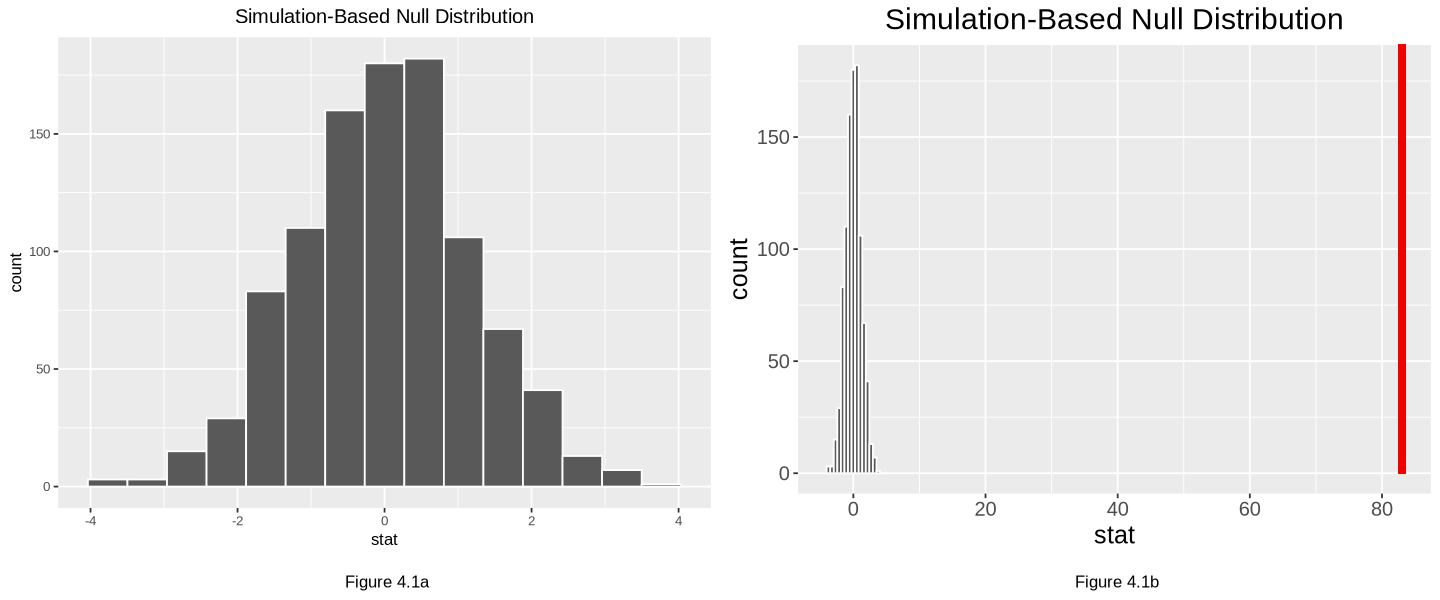

In [18]:
options(repr.plot.width = 12, repr.plot.height = 5)

# Visualize Bootstrap Distribution with and without calculated test statistic
bootstrap_perimeter <- visualize(bootstrap_dist_perimeter)+
    labs(caption = "\n Figure 4.1a") +
    theme(text = element_text(size = 10),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))


bootstrap_perimeter_hist <- visualize(bootstrap_dist_perimeter) +
    shade_p_value(test_stat_mean_perimeter, direction = "right")+
    labs(caption = "\n Figure 4.1b") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))

grid.arrange(bootstrap_perimeter, bootstrap_perimeter_hist, nrow= 1)

#### 4.1.2 Bootstrapping Method: Confidence Intervals
In order to find the 95% confidence interval for the difference in perimeter means, We will generate a bootstrap distribution using 1000 bootstrap samples from each rice group and then calculate the $97.5th$ and $2.5th$ quantiles to get the lower and upper bounds of the interval. 

In [14]:
# Generate bootstrap distribution for difference in perimeter means
bootstrap_perimeter_dist <- cleaned_rice_data %>%
    specify(formula = perimeter ~ class) %>%
    generate(type = "bootstrap", reps = 1000) %>%
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

# Calculate the 95% confidence interval for the difference in perimeter means
bootstrap_perimeter_ci <- get_ci(bootstrap_perimeter_dist, level = 0.95)
bootstrap_perimeter_ci

lower_ci upper_ci
1 56.6359  59.42114

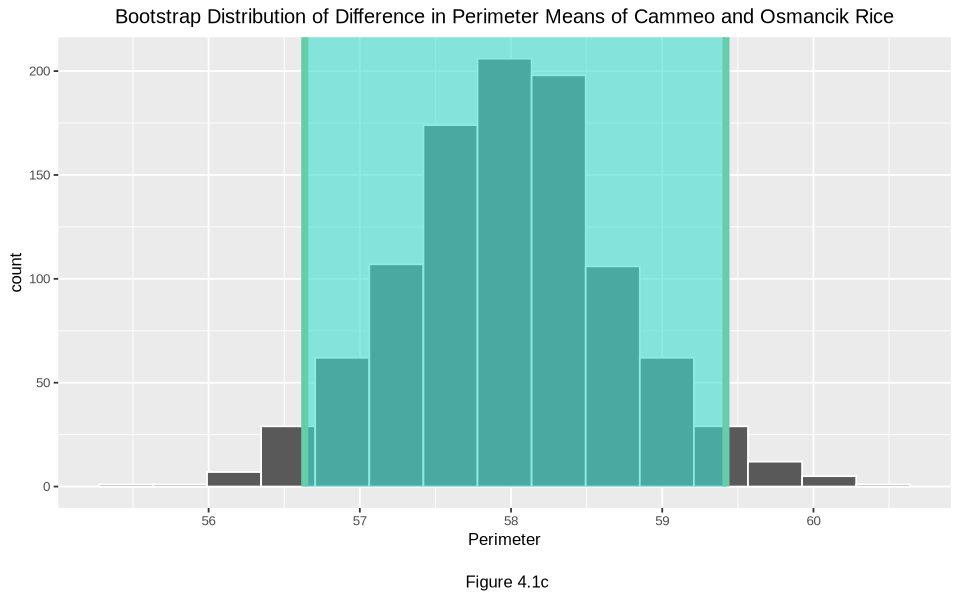

In [15]:
options(repr.plot.width = 8, repr.plot.height = 5)

# Visualize the bootstrap distribution and confidence interval
bootstrap_perimeter_dist_ci <- visualize(bootstrap_perimeter_dist) +
    shade_ci(bootstrap_perimeter_ci) +
    labs(x = "Perimeter", 
         title = "Bootstrap Distribution of Difference in Perimeter Means of Cammeo and Osmancik Rice", 
         caption = "\n Figure 4.1c") +
    theme(text = element_text(size = 10),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))

bootstrap_perimeter_dist_ci

#### 4.1.3 Central Limit Theorem (CLT) Method: Hypothesis Testing Using Two Sample $t$-test

Since we are uncertain of our population distribution being Normally Distributed, using Central Limit Theorem to perform a difference in means z-test would be ideal. CLT states that for a sufficiently large sample, in our case 3810 observations, the sampling distribution of that sample would approximately follow the Normal Distribution regardless of the population distribution. By that end, our difference in means follows:


$\bar{X}_1-\bar{X}_2\sim N\left(\mu_1 - \mu_2, \sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}\right)$

As Normality condition is met, a two sample t-test can be performed with 5% significance level to test whether Cammeo has a larger mean perimeter than Osmancik.


In [16]:
#two sample t-test for difference in mean perimeter
t_test_perimeter <- broom::tidy(t.test(x = cammeo_sample$perimeter,
       y = osmancik_sample$perimeter,
       alternative = "greater"))
t_test_perimeter

estimate estimate1 estimate2 statistic p.value parameter conf.low conf.high
1 58.02344 487.4389  429.4155  83.04477  0       3316.182  56.87386 Inf      
  method                  alternative
1 Welch Two Sample t-test greater

As our test statistic falls quite deep in the right tail, our p-value for the t-test is quite small such that the broom::tidy function rounds it upto 0. This suggests that the null is rejected and we must conclude that the mean perimeter for Cammeo is indeed larger than the mean perimeter for Osmancik Rice. 

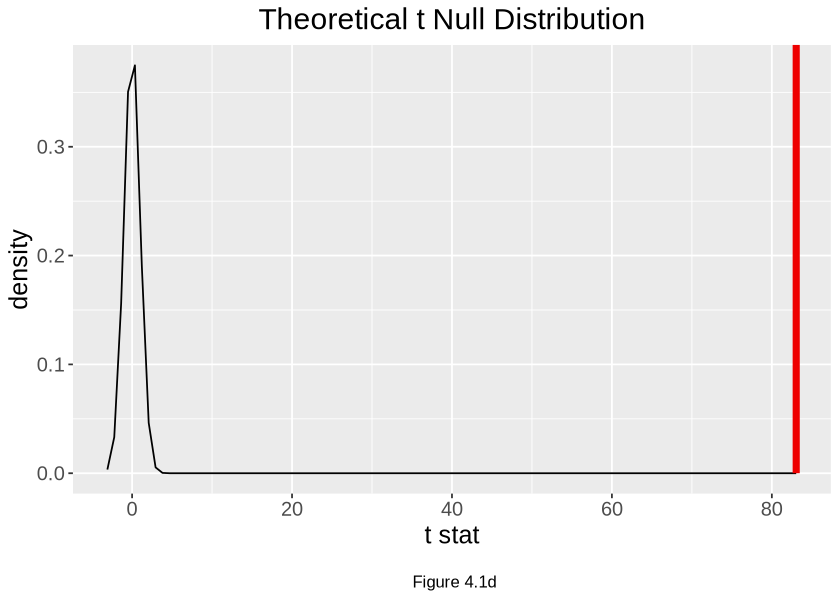

In [17]:
options(repr.plot.width = 7, repr.plot.height = 5)

#Pulling test statistic
test_stat_clt_perim <- t_test_perimeter %>%
pull(statistic)


#Visualizing t-distribution according to null hypothesis

t_null_dist <- cleaned_rice_data |>
        specify(formula = perimeter ~ class) |>
        assume(distribution = "t")

t_null_visual<- visualize(t_null_dist) + shade_p_value(test_stat_clt_perim, direction = "right") +
                labs(caption = "\n Figure 4.1d") +
                theme(text = element_text(size = 15),
                      plot.title = element_text(hjust = 0.5),
                      plot.caption = element_text(size = 10, hjust = 0.5))

t_null_visual

#### 4.1.4 Central Limit Theorem (CLT) Method: Confidence Intervals

We can use the difference of mean distribution presented above to construct a CI, and compare it with the CI produced with bootstrapping for further analysis. For continuity purposes, we will construct a 95% Confidence Interval.


In [18]:
# 95% confidence interval for difference in mean perimeter between Cammeo and Osmancik using CLT
perimeter_diff_means_ci <- 
    tibble(
        perimeter_lower_ci = mean(cammeo_sample$perimeter) - mean(osmancik_sample$perimeter) - 
                             qnorm(1-(0.05/2)) *
                             sqrt(var(cammeo_sample$perimeter)/length(cammeo_sample$perimeter) + var(osmancik_sample$perimeter)/length(osmancik_sample$perimeter)),
        perimeter_upper_ci = mean(cammeo_sample$perimeter) - mean(osmancik_sample$perimeter) + 
                             qnorm(1-(0.05/2)) * 
                             sqrt(var(cammeo_sample$perimeter)/length(cammeo_sample$perimeter) + var(osmancik_sample$perimeter)/length(osmancik_sample$perimeter))
    )

perimeter_diff_means_ci

perimeter_lower_ci perimeter_upper_ci
1 56.65401           59.39286

### 4.2 Hypothesis Testing: Difference in Means for `major_axis_length`

In this section we will test the **Difference in Means** of `major_axis_length` between the two classes (**Cammeo** & **Osmancik**) where our hypotheses are as follows:

$$H_0: \mu_1 - \mu_2 = 0$$
$$H_1: \mu_1 - \mu_2 \gt 0 $$

#### 4.2.1 Bootstrapping Method: Hypothesis Testing 

In [19]:
#Using infer workflow to generate study H_0 of diff in means (major_axis_length) for both types of rice

bootstrap_dist_mal <- cleaned_rice_data |>
    specify(formula = major_axis_length ~ class) |>
    hypothesize(null = "independence") |>
    generate(type = "permute", reps = 1500) |>
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

##### Calculating Test Statistic 

In [20]:
#Calculating corresponding test statistic

test_stat_mal <- ((summary_rice$mean_mal[1] - summary_rice$mean_mal[2])/sqrt(((summary_rice$sd_mal[1])^2/ n_cammeo) + ((summary_rice$sd_mal[2])^2/ n_osmancik)))

Using this t-statistic we can now generate our p-value to determine whether or not we should reject $H_0$

##### Visualizing Bootstrap Results

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


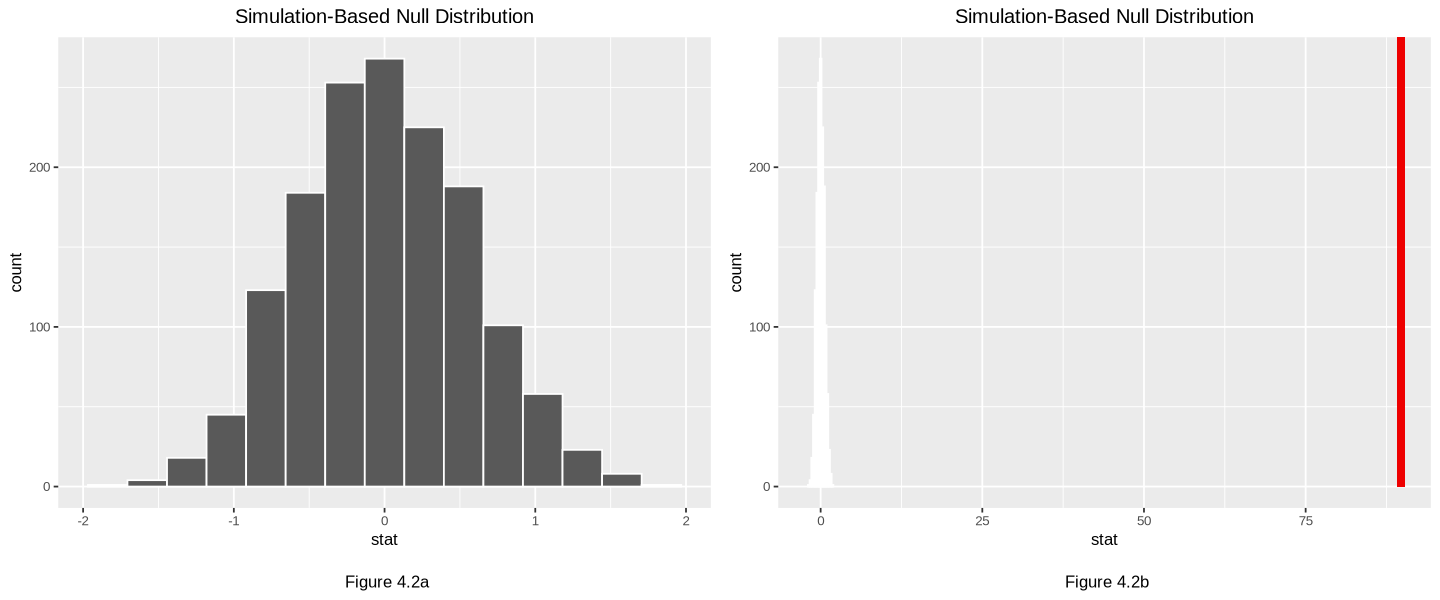

In [21]:
options(repr.plot.width = 12, repr.plot.height = 5)

#Rendering Bootstrap distribution with and without calculated test statistic v-line
bootstrap_mal <- visualize(bootstrap_dist_mal) +
    labs(caption = "\n Figure 4.2a") +
    theme(text = element_text(size = 10),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))

bootstrap_mal_t <- visualize(bootstrap_dist_mal) +
    shade_p_value(test_stat_mal, direction = "right") +
    labs(caption = "\n Figure 4.2b") +
    theme(text = element_text(size = 10),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))


grid.arrange(bootstrap_mal, bootstrap_mal_t, nrow = 1)

##### Obtaining p-value

In [22]:
get_p_value(bootstrap_dist_mal, test_stat_mal, direction = 'right')

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
1 0

We can observe our p-value is being reported to be 0 by the `get_p_value()` function, this indicates that it is near zero but not actually zero.

##### Results
We can now observe that our p-value is very close to zero. According to our significance value of 5% or $\alpha = 0.05$, we can now reject the Null Hypothesis of $H_0 : \mu_1 - \mu_2 = 0$. This indicates that the Cammeo `major_axis_length` mean is greater than that of `Osmancik`.

#### 4.2.2 Bootstrapping Method: Confidence Intervals

In [23]:
#Constructing Bootstrap Distribution at 1500 reps
mal_bootstrap_ci <- cleaned_rice_data |>
    specify(formula = major_axis_length ~ class) |>
    generate(type = "bootstrap", reps = 1500) |>
    calculate(stat = "diff in means", order = c("Cammeo", "Osmancik"))

In [24]:
#Obtaining Bootstrap Confidence Intervals at a 95% confidence level
mal_ci <- mal_bootstrap_ci |>
    get_ci(type= 'percentile', level= 0.95)

mal_ci

lower_ci upper_ci
1 28.52621 29.84611

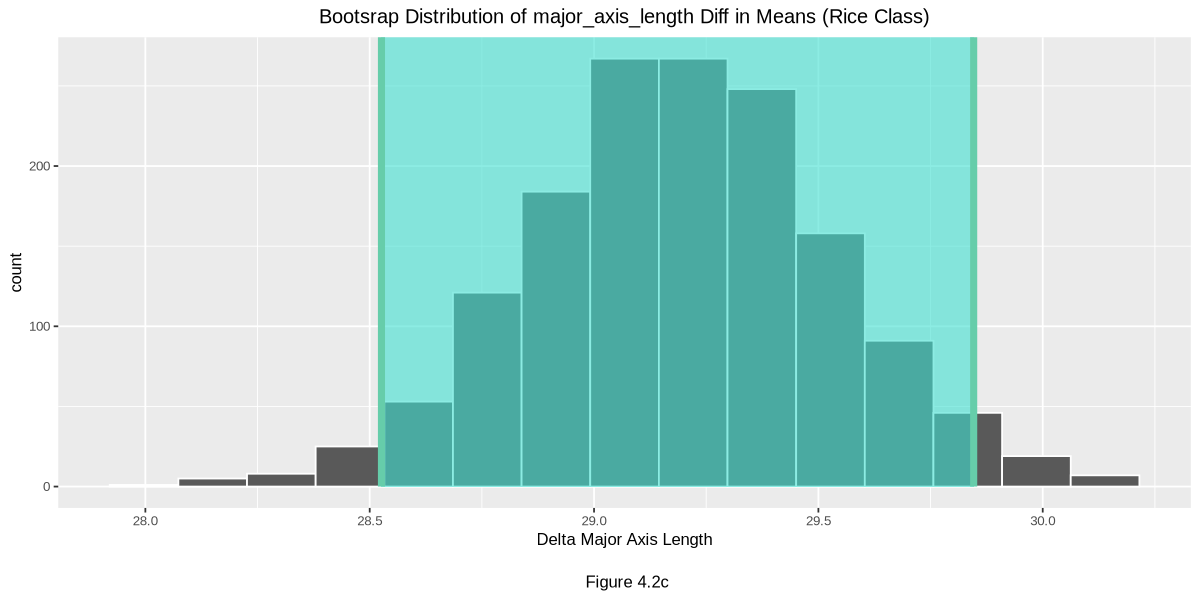

In [25]:
options(repr.plot.width = 10, repr.plot.height = 5)

#Visualizing Bootrap Distribution w/ shaded Bootstrap CI's

bt_dist_ci<- visualize(mal_bootstrap_ci) + 
        shade_confidence_interval(endpoints = mal_ci) +
        labs(title= 'Bootsrap Distribution of major_axis_length Diff in Means (Rice Class)',
             x= 'Delta Major Axis Length', caption= "\n Figure 4.2c") +
        theme(text = element_text(size = 10),
              plot.title = element_text(hjust = 0.5),
              plot.caption = element_text(size = 10, hjust = 0.5))

bt_dist_ci

#### 4.2.3 Central Limit Theorem (CLT) Method: Hypothesis testing Using two sample t-test 

Figure 2b above shows that Cammeo rice has a longer major axis compared to Osmancik rice but our dataset only represents a sample of the rice species and not all Cammeo and Osmancik rice therefore, it is necessary to conduct hypothesis testing. The shape of our underlying population distribution is unknown but our dataset is quite large so we can say that we are using a large sample size (n) for our hypothesis testing and can therefore rely on CLT. Conducting a t-test using a large dataset means that it will asymptotically approach a normal distribution due to CLT. We are also assuming that we have 2 independent random samples, one from each population of rice species, which aligns with the assumptions and conditions of CLT. The hypotheses being tested are: 

- $H_0: \mu_1 - \mu_2 = 0$
- $H_A: \mu_1 - \mu_2  > 0$

where $\mu_1$ = Mean major axis length of Cammeo rice and $\mu_2$ = Mean major axis length of Osmanick rice 

We will be using a 0.05 significance level for our hypothesis testing.

In [26]:
#use t test to obtain test statistic and p value
t_test_mal <- broom::tidy(
    t.test(mu = 0, 
           x = cammeo_sample$major_axis_length, 
           y = osmancik_sample$major_axis_length,
          alternative = 'greater'))
t_test_mal

estimate estimate1 estimate2 statistic p.value parameter conf.low conf.high
1 29.19083 205.4786  176.2878  89.77632  0       3310.051  28.65586 Inf      
  method                  alternative
1 Welch Two Sample t-test greater

Since our test statistic is quite large with a value of 89.8, our p value is very small (approximately 0) which indicates that we should reject our null hypothesis at the 0.05 significance level. The results show that there is a significant difference between the mean major axis length of Cammeo rice and the mean major axis length of Osmancik rice, with Cammeo rice having a greater major axis length. 


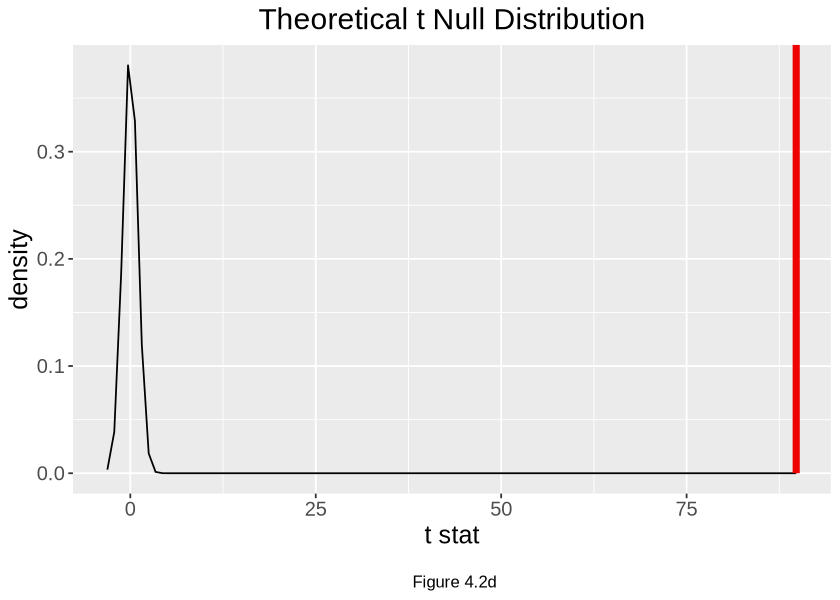

In [27]:
options(repr.plot.width = 7, repr.plot.height = 5)


#Pulling test statistic
test_stat_clt_mal <- t_test_mal %>%
pull(statistic)


#Visualizing t-distribution according to null hypothesis

t_null_dist <- cleaned_rice_data |>
        specify(formula = major_axis_length ~ class) |>
        assume(distribution = "t")

t_null_dist_vis <- visualize(t_null_dist) + shade_p_value(test_stat_clt_mal, direction = "right") +
    labs(caption = "\n Figure 4.2d") +
    theme(text = element_text(size = 15),
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(size = 10, hjust = 0.5))

t_null_dist_vis

#### 4.2.4 Central Limit Theorem (CLT) Method: Confidence Intervals

In [28]:
#Calculating Mean and Standard error per rice class
rice_summary <- cleaned_rice_data |>
    group_by(class)|>
    summarize(sample_mean= mean(major_axis_length), sample_std_error= sd(major_axis_length)/sqrt(n()))


#Assigning previous values to variables 
cammeo_mean <- rice_summary$sample_mean[1]
cammeo_var <- (rice_summary$sample_std_error[1])**2
osmancik_mean <-  rice_summary$sample_mean[2]
osmancik_var <- (rice_summary$sample_std_error[2])**2


#Calculating CLT Confidence Intervals
rice_clt_ci <- 
    tibble(lower_ci = qnorm(0.05, (cammeo_mean-osmancik_mean), sqrt(cammeo_var + osmancik_var)),
        upper_ci = qnorm(0.95, (cammeo_mean-osmancik_mean), sqrt(cammeo_var + osmancik_var)))


head(rice_summary)
head(rice_clt_ci)

class    sample_mean sample_std_error
1 Cammeo   205.4786    0.2559579       
2 Osmancik 176.2878    0.2005207

lower_ci upper_ci
1 28.65601 29.72566

### 4.4 Confidence Interval from CLT vs. Bootstrapping

In [29]:
# Bootstrapping VS CLT Confidence Intervals for difference in perimeter means
perimeter_ci <- tibble(method = c("Bootstrapping", "CLT"),
                       lower_ci = c(bootstrap_perimeter_ci$lower_ci, 
                                    perimeter_diff_means_ci$perimeter_lower_ci),
                       upper_ci = c(bootstrap_perimeter_ci$upper_ci, 
                                    perimeter_diff_means_ci$perimeter_upper_ci))
perimeter_ci

method        lower_ci upper_ci
1 Bootstrapping 56.63590 59.42114
2 CLT           56.65401 59.39286

Due to our sample size being quite large, our confidence intervals predicted by both methods do not differ by much. The margin of error for difference in perimeter is +- 0.04 more for Bootstrapping than CLT, leading to a wider CI.  A reason for this is because in our bootstrapping method, we are estimating our population variance using sample variance which leads to more uncertainty.  Although both methods have their own qualms, in our case, we prefer the CLT as it has more precision, which would have significantly demonstrated itself had the sample size been quite small.

In [30]:
# Bootstrapping VS CLT Confidence Intervals for difference in major axis length
# means
mal_ci1 <- tibble(method = c("Bootstrap", "CLT"), 
                 lower_ci = c(mal_ci$lower_ci, rice_clt_ci$lower_ci),
                 upper_ci = c(mal_ci$upper_ci, rice_clt_ci$upper_ci))
mal_ci1

method    lower_ci upper_ci
1 Bootstrap 28.52621 29.84611
2 CLT       28.65601 29.72566

## 5. Discussion 

### 5.1 Findings Summary & Conclusions

#### 5.1.1 Summary for `perimeter`

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


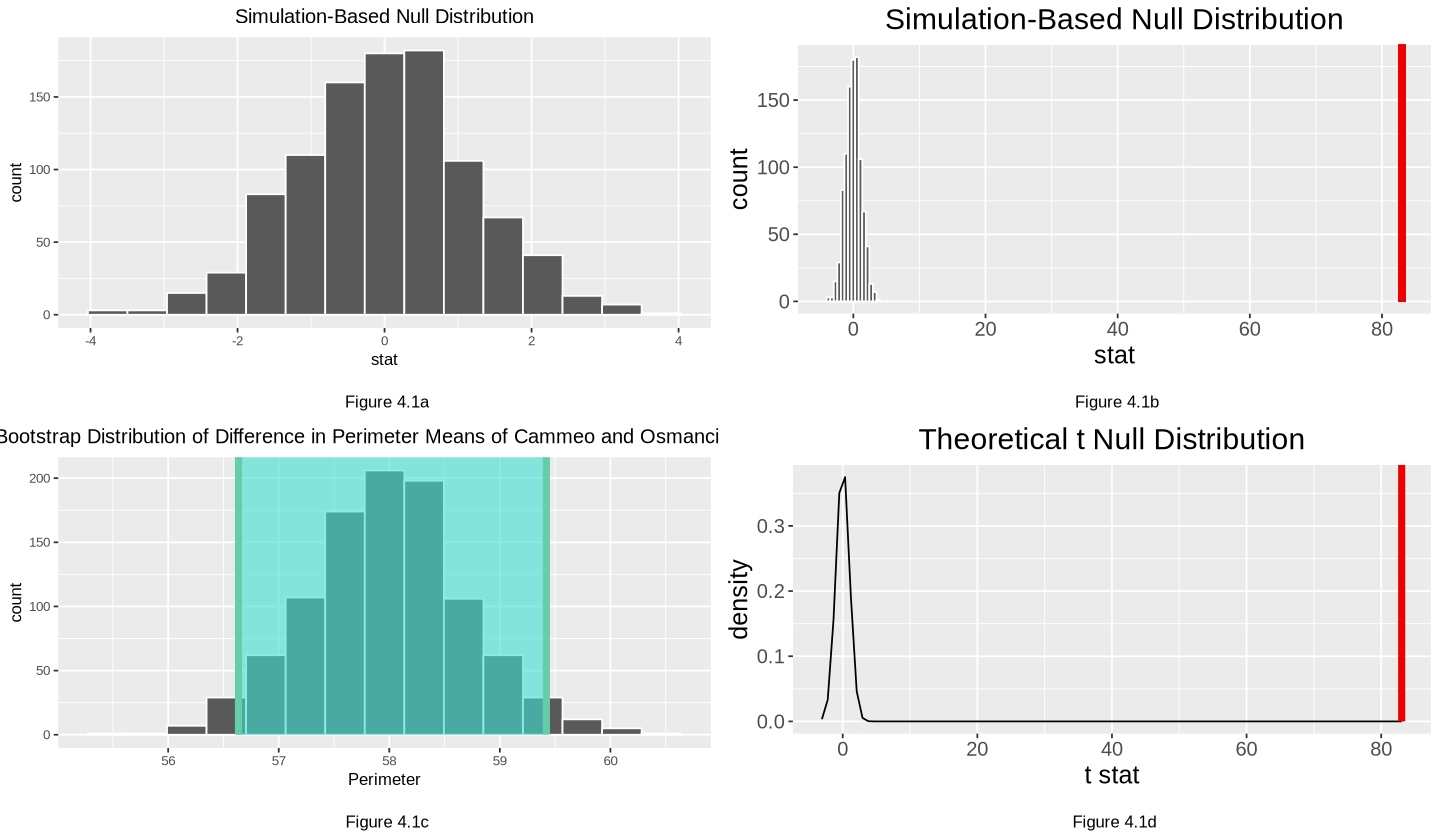

In [41]:
options(repr.plot.width = 12, repr.plot.height = 7)

#Arranging all perimeter visualizations in a tidy manner
grid.arrange(bootstrap_perimeter, bootstrap_perimeter_hist, bootstrap_perimeter_dist_ci, t_null_visual, ncol = 2)

In figure 4.1a we can observe our Bootstrap Distribution obtained from the `infer` library. Alongside in figure 4.1b, we observe our test statistic with the bootstrap distribution, our test statistic allowed us to calculate our $p$-value (refer to 4.1.1) and consequently reject our null hypothesis. 

As previously mentioned in our report, we consider the CLT method to have a higher precision. Due to our lower and upper quantiles (refer to table 1, 4.4), we are 95% confident that that the true perimeter difference in means between Cammeo and Osmancik rice is between $56.65401$ and $59.39286$ (These Confidence Intervals are visualized in 4.1c above).

### 5.1.2 Summary for `major_axis_length` 

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


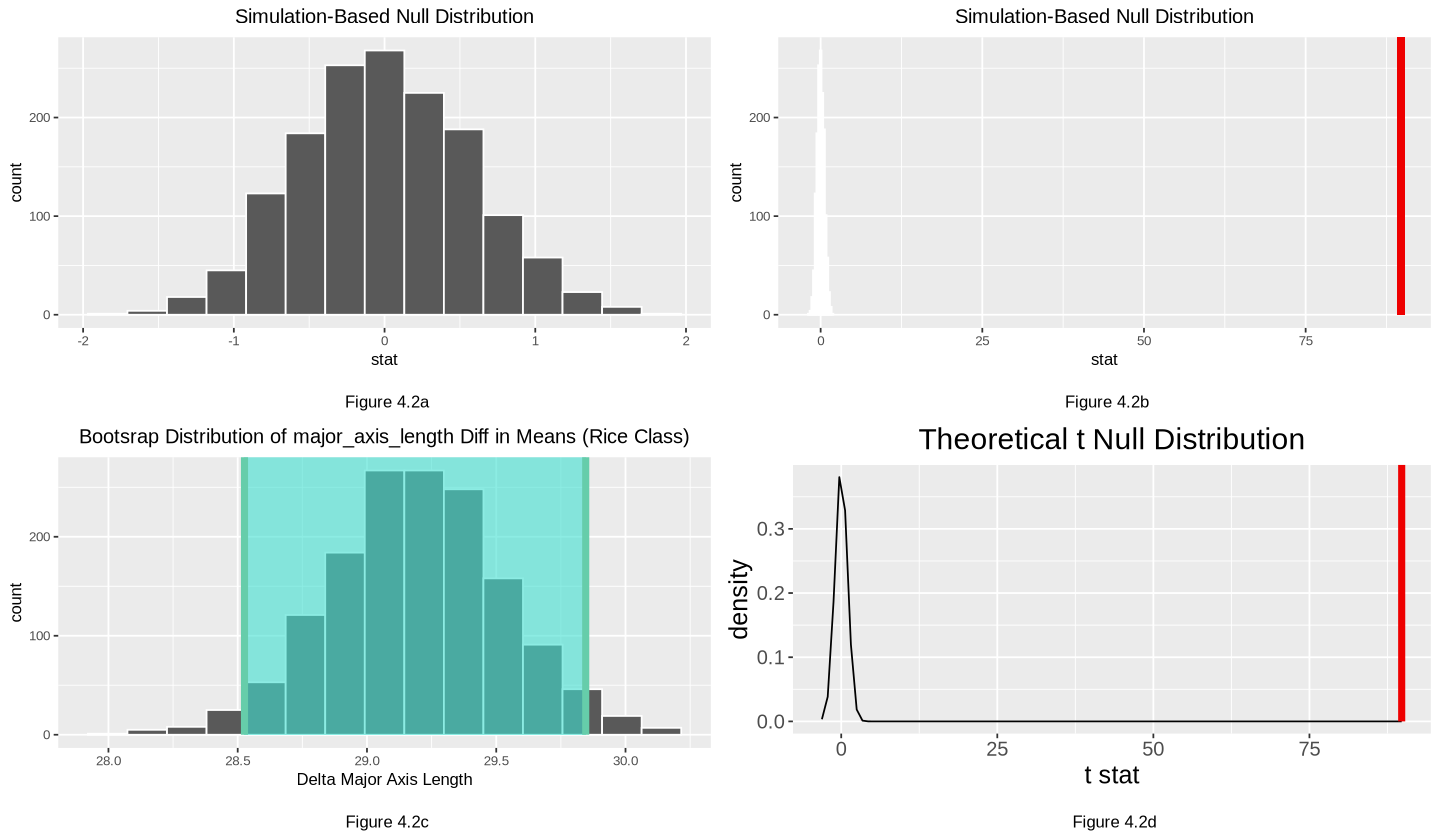

In [42]:
options(repr.plot.width = 12, repr.plot.height = 7)

#Arranging all major_axis_length visualizations in a tidy manner
grid.arrange(bootstrap_mal, bootstrap_mal_t, bt_dist_ci, t_null_dist_vis, ncol= 2)

In figure 4.2a we can observe our Bootstrap Distribution obtained from the `infer` library. Alongside in figure 4.1b, we observe our test statistic with the bootstrap distribution, our test statistic allowed us to calculate our $p$-value (refer to 4.2.1) and consequently reject our null hypothesis. 

Due to our lower and upper quantiles (refer to table 1, 4.4), we are 95% confident that that the true Major Axis Length difference in means between Cammeo and Osmancik rice is between $28.65601$ and $29.72566$ (These Confidence Intervals are visualized in 4.2c above).

Overall our findings are statistically significant since our $p$-value was calculated to be smaller than our stated signficance level of $\alpha= 0.05$. Even though our values were shockingly low, we did expect to find exceptionally significant data due to our high correlation between the chosen variables (refer to figure 1).

### 5.2 Results of Two-Sample $t$-Tests 

For both of our t-tests done using the bootstrapping method and under the assumption of CLT respectively, all differences in mean tests conclude that Cammeo Rice has a larger mean perimeter and mean major axis length than Osmancik Rice. From our hypothesis testing, we also found extremely low p-values suggesting statistical significance of our findings.  

### 5.3 Impact of our findings

These conclusions can mean that classification between Cammeo and Osmancik would be much easier given the two predictors we are interested in. What could be more interesting is to explore is how much does the difference vary by for each variable `perimeter` and `major_axis_length`. For the aforementioned, we could perform more difference in means hypothesis tests but test a specific value that they differ by. For difference in `perimeter`, it could be 58, and for difference in `major_axis_length` it could be 29. Such tests could lead to further interesting revelations about each type of Rice (Cammeo and Osmancik in our case).

These findings could be important for business in the agricultural and farming sector. It is also within our interest to explore our variables, `perimeter` and `major_axis_length` further to see which farming techniques could optimize the rice growth and in turn increase profits.

## References
- Rice (Cammeo and Osmancik). (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5MW4Z.

- [Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285](https://www.sciencedirect.com/science/article/pii/S0168169921003021)

- [Tuğrul, B. (2022). Classification of five different rice seeds grown in Turkey with deep learning methods . Communications Faculty of Sciences University of Ankara Series A2-A3 Physical Sciences and Engineering , 64 (1) , 40-50 . DOI: 10.33769/aupse.1107590](https://dergipark.org.tr/en/pub/aupse/issue/68241/1107590)